In [1]:
import os
import scripts

# Paths
model_path = '../resources/models'
data_path = '../data'

2025-12-04 18:15:24.088439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Import data and models

In [2]:
train_data, val_data, test_data = scripts.load_processed_data(data_path, 'over_under')

In [ ]:
mlp_model = scripts.MLPModel()
mlp_model.load_model(os.path.join(model_path, 'mlp_over_under_trained.keras'))

models = {
    'knn': None,
    # 'lin_reg': None,
    # 'tree': None
}

for model_name in models.keys():
    models[model_name] = scripts.load_model(model_path, model_name)

models['mlp'] = mlp_model.model

# Evaluation

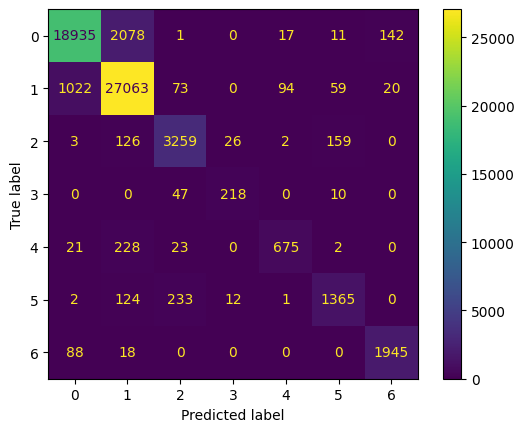

In [ ]:
actuals = test_data['Cover_Type']
eval_path = '../resources/evaluations'

if not os.path.exists(eval_path):
    os.makedirs(eval_path)

for model_name, model in models.items():
    preds = model.predict(test_data.drop(columns=['Cover_Type']))
    conf, mcm, class_report, mcc = scripts.evaluate(actuals, preds)

    # Save evaluation results
    print(f'Evaluations for {model_name} model:\n')
    print('Classification Report:\n')
    print(class_report)
    print(f'\nMatthews Correlation: {mcc}\n\n')

    """
    with open(f'{eval_path}/over_under_evaluations.txt', 'w') as f:
        f.write(f'Evaluations for {model_name} model:\n')
        f.write('Classification Report:\n')
        f.write(class_report)
        f.write(f'\nMatthews Correlation: {mcc}\n\n')
    """

    # Save confusion matrix figure
    conf.plot()
    fig_path = f'{eval_path}/{model_name}_over_under_confusion_matrix.png'
    # conf.figure_.savefig(fig_path)

# Explainer

In [12]:
test_strat = scripts.sample_stratify(test_data, 'Cover_Type', 2000)
x_strat = test_strat.drop(columns=['Cover_Type'])

## MLP

PermutationExplainer explainer: 58103it [31:38, 30.52it/s]                           
/tmp/ipykernel_9975/2750232919.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test_data.drop(columns=['Cover_Type']), show=False)


NameError: name 'eval_path' is not defined

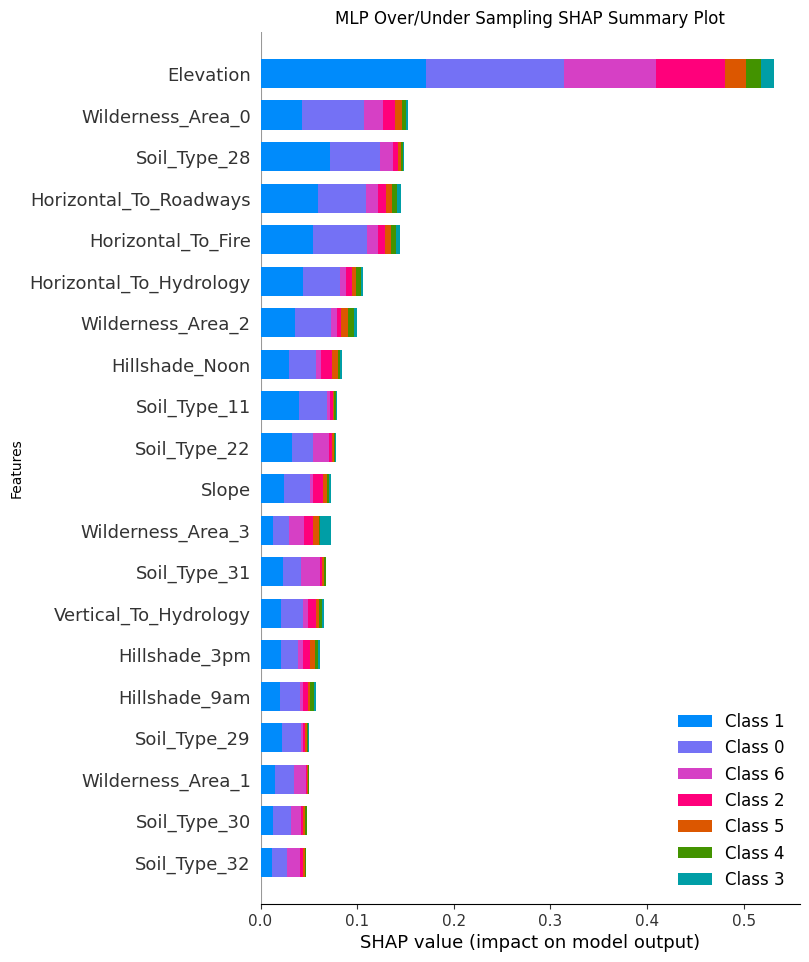

In [9]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(mlp_model.model, test_data.drop(columns=['Cover_Type']))
shap_values = explainer(test_data.drop(columns=['Cover_Type']))

shap.summary_plot(shap_values, test_data.drop(columns=['Cover_Type']), show=False)
plt.title('MLP Over/Under Sampling SHAP Summary Plot')
plt.xlabel('SHAP value (impact on model output)')
plt.ylabel('Features')
plt.savefig(f'{eval_path}/mlp_over_under_shap_summary.png')

## KNN

In [ ]:
knn_model = models['knn']
knn_explainer = shap.Explainer(knn_model.predict, test_data.drop(columns=['Cover_Type']))
knn_shap_values = knn_explainer(x_strat)

TypeError: KNeighborsClassifier.predict() missing 1 required positional argument: 'X'

In [ ]:
shap.summary_plot(knn_shap_values, test_data.drop(columns=['Cover_Type']), show=False)
plt.title('KNN Over/Under Sampling SHAP Summary Plot')
plt.xlabel('SHAP value (impact on model output)')
plt.ylabel('Features')
plt.savefig(f'{eval_path}/knn_over_under_shap_summary.png')